In [29]:
import numpy as np
import pandas as pd 
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout


In [30]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

## Computer Vision Demo - Identifying Smiles

This demo will train a basic tensorflow convolutional neural network to identify faces that are smiling. We will use the Large-Scale CelebFaces Attributes Dataset available [here](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).


### 1. Loading and Preparing Data

First we will fit take a subset of the data, pre-process using keras image processing and split into train and test sets.


In [31]:
attributes = pd.read_csv('data/list_attr_celeba.csv')[3000:4000]
img_folder = "data/img_align_celeba/img_align_celeba/"
img_files = attributes['image_id']
#images = [cv2.resize(cv2.imread(img_folder + file),(64,64)) for file in img_files[:2000]]
X = np.array([img_to_array(load_img(img_folder + file, target_size=(128,128))) for file in img_files])
y = attributes['Smiling'].values == 1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2)

Now we will visualise a sub-sample the data including the label values of interest ('Smiling')

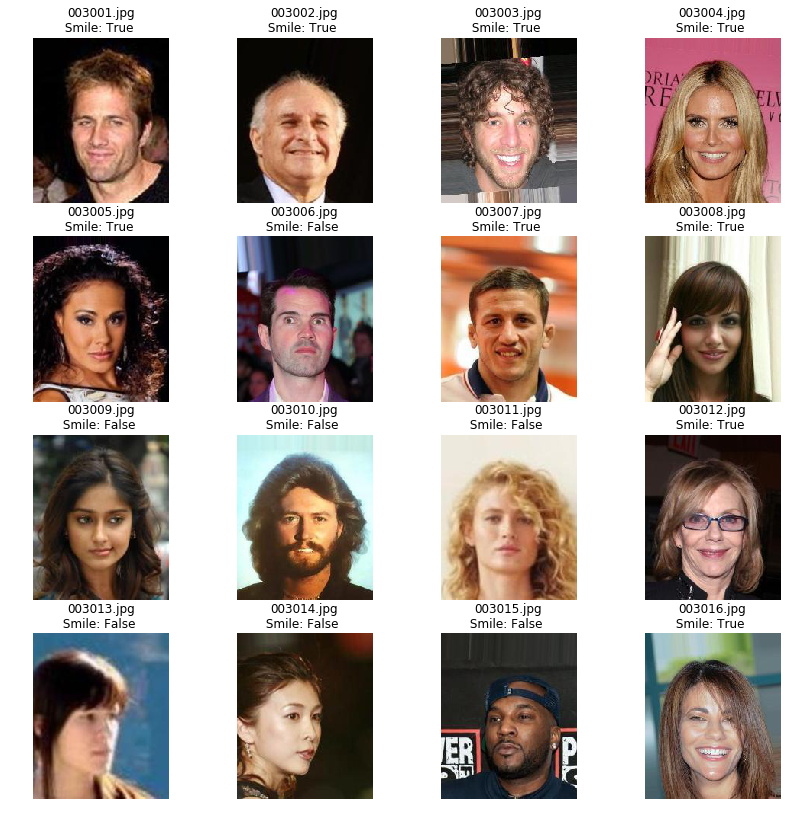

In [32]:
plt.figure(figsize=(14,14))
for i, file in enumerate(img_files[:16]):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(img_folder + '/' + file)
    plt.imshow(img)
    plt.title(file + "\n Smile: "+ str(y[i]) + "  ")
    plt.axis('off')

Data appears to be well annotated, cropped and centred.

Now we will use the train-test split defined earlier to set up our train set and test set using a basic data generator that only performs rescaling of the RGB values from 0-255 to 0-1.

In [33]:
base_datagen = ImageDataGenerator(rescale = 1./255) 
train_set = base_datagen.flow(x_train, y_train, batch_size=20)
test_set = base_datagen.flow(x_test, y_test, batch_size=20)

### 2. Fitting a Basic Model

For model architecture we will use a single 2D convolution layer with kernels of size 3x3 to identify visual patterns. Which will be flattened and fed into dense layers for decision making. The final layer is a single sigmoid output and binary crossentropy loss function since we have are making a binary prediciton.

In [34]:
cnn_model_basic = Sequential()
cnn_model_basic.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_model_basic.add(Conv2D(32, (3, 3), activation="relu"))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model_basic.add(Flatten())
cnn_model_basic.add(Dense(activation = 'relu', units = 128))
cnn_model_basic.add(Dense(activation = 'sigmoid', units = 1))
cnn_model_basic.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model_basic.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
flatten_5 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65028224  
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 65,029,249
Trainable params: 65,029,249
Non-trainable params: 0
_________________________________________________________________


Now we will fit the model described above over 8 epochs with the train and test data sets prepared earlier and examine the accuracy of each.

In [35]:
start_time = time.time()
basic_fit = cnn_model_basic.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Epoch 1/8
40/40 [==============================] - 20s 506ms/step - loss: 7.5023 - acc: 0.5213 - val_loss: 1.3706 - val_acc: 0.5150
Epoch 2/8
40/40 [==============================] - 19s 467ms/step - loss: 0.7183 - acc: 0.6612 - val_loss: 0.6602 - val_acc: 0.6650
Epoch 3/8
40/40 [==============================] - 19s 469ms/step - loss: 0.6406 - acc: 0.7788 - val_loss: 0.5754 - val_acc: 0.7100
Epoch 4/8
40/40 [==============================] - 19s 472ms/step - loss: 0.3459 - acc: 0.8587 - val_loss: 0.6921 - val_acc: 0.7150
Epoch 5/8
40/40 [==============================] - 19s 473ms/step - loss: 0.1864 - acc: 0.9450 - val_loss: 0.7947 - val_acc: 0.7450
Epoch 6/8
40/40 [==============================] - 19s 472ms/step - loss: 0.0950 - acc: 0.9787 - val_loss: 0.6512 - val_acc: 0.6950
Epoch 7/8
40/40 [==============================] - 19s 476ms/step - loss: 0.1312 - acc: 0.9675 - val_loss: 0.6998 - val_acc: 0.7900
Epoch 8/8
40/40 [==============================] - 19s 473ms/step - loss: 0.

If we add additional epochs with the same data we find validation accuracy starts to plateau while training accuracy appears to be over-fit.

In [36]:
start_time = time.time()
basic_fit2 = cnn_model_basic.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Epoch 1/8
40/40 [==============================] - 19s 473ms/step - loss: 0.0863 - acc: 0.9762 - val_loss: 0.6714 - val_acc: 0.7500
Epoch 2/8
40/40 [==============================] - 19s 476ms/step - loss: 0.1447 - acc: 0.9800 - val_loss: 0.6762 - val_acc: 0.7500
Epoch 3/8
40/40 [==============================] - 19s 471ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.8341 - val_acc: 0.7550
Epoch 4/8
40/40 [==============================] - 19s 471ms/step - loss: 0.2715 - acc: 0.9787 - val_loss: 0.7455 - val_acc: 0.7700
Epoch 5/8
40/40 [==============================] - 19s 471ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.8571 - val_acc: 0.7850
Epoch 6/8
40/40 [==============================] - 19s 471ms/step - loss: 0.1044 - acc: 0.9787 - val_loss: 0.8603 - val_acc: 0.7800
Epoch 7/8
40/40 [==============================] - 19s 476ms/step - loss: 4.9678e-04 - acc: 1.0000 - val_loss: 0.9837 - val_acc: 0.7950
Epoch 8/8
40/40 [==============================] - 19s 474ms/step - loss

Our basic model has reasonable validation accuracy around 80% but has clearly overfit to the training data with train accuracy 100%. Training time for 6 epochs was ..., we will first try to improve the training speed for this simple model. 

### 3. Improving Training Speed

In order to improve training speed we will decrease the complexity of downstream network layers by A: introducing stride so that convolutions are not applied to every position. and B: introduce a max pooling layer to downscale the convolution output. The approaches will be compared for speed and accuracy.

In [37]:
cnn_model_stride = Sequential()
cnn_model_stride.add(Conv2D(32, (3, 3), strides=2, activation="relu", input_shape=(128, 128, 3)))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_model_basic.add(Conv2D(32, (3, 3), activation="relu"))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model_stride.add(Flatten())
cnn_model_stride.add(Dense(activation = 'relu', units = 128))
cnn_model_stride.add(Dense(activation = 'sigmoid', units = 1))
cnn_model_stride.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model_stride.summary()
start_time = time.time()
basic_fit = cnn_model_stride.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
flatten_6 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 16,258,177
Trainable params: 16,258,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
40/40 [==============================] - 6s 142ms/step - loss: 5.7715 - acc: 0.5337 - val_loss: 0.6436 - val_acc: 0.6450
Epoch 2/8
40/40 [==============================] - 5s 126ms/step - loss: 0.6265 - acc: 0.7063 - val_loss: 0.5

Introducing the strides = 2 has improved training time dramatically over 8 epochs with comparable validation accuracy.

In [38]:
cnn_model_pooling = Sequential()
cnn_model_pooling.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
cnn_model_pooling.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_model_basic.add(Conv2D(32, (3, 3), activation="relu"))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model_pooling.add(Flatten())
cnn_model_pooling.add(Dense(activation = 'relu', units = 128))
cnn_model_pooling.add(Dense(activation = 'sigmoid', units = 1))
cnn_model_pooling.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model_pooling.summary()
start_time = time.time()
basic_fit = cnn_model_pooling.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 6 epochs: {0}".format(training_time))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 16,258,177
Trainable params: 16,258,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
40/40 [==============================] - 7s 181ms/step - loss: 3.2902 - acc: 0.5312 - val_loss: 0.

A max pooling layer also dramatically improves training time without a significant loss in validation accuracy.

The stride approach appears the best so far, so this architecture will be used for subsequent modelling.

* Other Approaches to Consider: * Using transfer learning to import pre-trained layers, Reducing image resolution, 

### 4. Reducing Overfitting
In order to reduce the overfitting above (train accuracy = 1 while validation accuracy ~ .8) we have a few options. We could increase the amount of data we use (there are many more samples in the dataset), but in this demo we will instead add some random distortion to the training data such that a single training image may appear slightly different between iterations. This is done using image data generator arguments. The test set will remain un-modified to be as representative of actual data as possible.


In [44]:
datagen_mods = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.15,
                                   zoom_range = 0.15, rotation_range = 10,                                
                                   horizontal_flip = True)
train_set_mod = datagen_mods.flow(x_train, y_train, batch_size=20)

In [45]:
cnn_model_stride = Sequential()
cnn_model_stride.add(Conv2D(32, (3, 3), strides=2, activation="relu", input_shape=(128, 128, 3)))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
#cnn_model_basic.add(Conv2D(32, (3, 3), activation="relu"))
#cnn_model_basic.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model_stride.add(Flatten())
cnn_model_stride.add(Dense(activation = 'relu', units = 128))
cnn_model_stride.add(Dense(activation = 'sigmoid', units = 1))
cnn_model_stride.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model_stride.summary()
start_time = time.time()
basic_fit = cnn_model_stride.fit_generator(train_set_mod,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 63, 63, 32)        896       
_________________________________________________________________
flatten_9 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 16,258,177
Trainable params: 16,258,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
40/40 [==============================] - 6s 149ms/step - loss: 4.1626 - acc: 0.5113 - val_loss: 0.8243 - val_acc: 0.4900
Epoch 2/8
40/40 [==============================] - 5s 127ms/step - loss: 0.7192 - acc: 0.5800 - val_loss: 0.

With the introduced data augmentations more training time might be required to get the best performance.

In [46]:
start_time = time.time()
basic_fit = cnn_model_stride.fit_generator(train_set_mod,
                         epochs = 16,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 16 epochs: {0}".format(training_time))

Epoch 1/16
40/40 [==============================] - 5s 130ms/step - loss: 0.5494 - acc: 0.7275 - val_loss: 0.6045 - val_acc: 0.7100
Epoch 2/16
40/40 [==============================] - 5s 129ms/step - loss: 0.5196 - acc: 0.7588 - val_loss: 0.5606 - val_acc: 0.7200
Epoch 3/16
40/40 [==============================] - 5s 128ms/step - loss: 0.4976 - acc: 0.7638 - val_loss: 0.5804 - val_acc: 0.7400
Epoch 4/16
40/40 [==============================] - 5s 128ms/step - loss: 0.5020 - acc: 0.7563 - val_loss: 0.5334 - val_acc: 0.7150
Epoch 5/16
40/40 [==============================] - 5s 129ms/step - loss: 0.4863 - acc: 0.7700 - val_loss: 0.5344 - val_acc: 0.7400
Epoch 6/16
40/40 [==============================] - 5s 128ms/step - loss: 0.4530 - acc: 0.7763 - val_loss: 0.5521 - val_acc: 0.7550
Epoch 7/16
40/40 [==============================] - 5s 129ms/step - loss: 0.4551 - acc: 0.7887 - val_loss: 0.5545 - val_acc: 0.7200
Epoch 8/16
40/40 [==============================] - 5s 128ms/step - loss: 0.

Validation accuracy is slightly less than previous models and training accuracy is reduced but number of epochs to reach the same validation accuracy is much higher, resulting in more training time.

We will now try a dropout layer to force the model to rely on more features when making decisions.

In [47]:
cnn_model_stride = Sequential()
cnn_model_stride.add(Conv2D(32, (3, 3), strides=2, activation="relu", input_shape=(128, 128, 3)))
cnn_model_stride.add(Dropout(.5))
cnn_model_stride.add(Flatten())
cnn_model_stride.add(Dense(activation = 'relu', units = 128))
cnn_model_stride.add(Dense(activation = 'sigmoid', units = 1))
cnn_model_stride.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
cnn_model_stride.summary()
start_time = time.time()
basic_fit = cnn_model_stride.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 63, 63, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 127008)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 16,258,177
Trainable params: 16,258,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
40/40 [==============================] - 7s 168ms/step - loss: 2.8272 - acc: 0.5250 - val_loss: 0

In [48]:
start_time = time.time()
basic_fit = cnn_model_stride.fit_generator(train_set,
                         epochs = 8,
                         validation_data = test_set)
end_time = time.time()
training_time =  end_time - start_time
print("Training time for 8 epochs: {0}".format(training_time))

Epoch 1/8
40/40 [==============================] - 6s 146ms/step - loss: 0.1352 - acc: 0.9638 - val_loss: 0.4395 - val_acc: 0.8150
Epoch 2/8
40/40 [==============================] - 6s 144ms/step - loss: 0.0960 - acc: 0.9750 - val_loss: 0.5468 - val_acc: 0.7600
Epoch 3/8
40/40 [==============================] - 6s 145ms/step - loss: 0.0707 - acc: 0.9787 - val_loss: 0.6077 - val_acc: 0.7800
Epoch 4/8
40/40 [==============================] - 6s 147ms/step - loss: 0.0450 - acc: 0.9900 - val_loss: 0.5142 - val_acc: 0.8000
Epoch 5/8
40/40 [==============================] - 6s 146ms/step - loss: 0.0454 - acc: 0.9887 - val_loss: 0.4979 - val_acc: 0.8100
Epoch 6/8
40/40 [==============================] - 6s 145ms/step - loss: 0.0277 - acc: 0.9925 - val_loss: 0.6299 - val_acc: 0.7950
Epoch 7/8
40/40 [==============================] - 6s 145ms/step - loss: 0.0212 - acc: 0.9937 - val_loss: 0.5389 - val_acc: 0.8200
Epoch 8/8
40/40 [==============================] - 6s 145ms/step - loss: 0.0059 - a

This architecture reaches similar validation accuracy to the other models while including a significant dropout rate.

### 5. Extending The Model

This model has significant limitations in that it classifies images that are all faces, cropped and aligned. In order to make the model more applicable and useful in the real world it could be combined with pre-trained face detection models like those in openCV that are able to identify and produce bounding boxes around faces in real life images. Those bounding boxes can be used to crop larger more complex images into ones that can be processed by a simpler model like this one.

### 6. Saving The Model for Deployment\

After training the model we can save the entire architecture and weights so that it can be used without having to re-train from scratch. After being saved, the model can be imported into command line programs, APIs, tensorflow servings (in Dockers) or other applications.

In [50]:
cnn_model_stride.save('stride_model.m5')